# 2022 드라마

In [8]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [9]:
df = pd.read_csv('./data_drama/2022년 방영 드라마.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20221226,"송중기 드라마 재벌집 막내아들, 넷플릭스에 이어서 jtbc 역대 시청률도 1순위? ...",2022 jtbc 역대 <b>드라마<\/b> 시청률 1순위! 재벌집 막내아들은 <b...,2022년 비지상파 jtbc 역대 드라마 시청률 1순위? 송중기 드라마 재벌집 막내...
1,20220921,2022년 방영예정 한국드라마 작은아씨들 후속작 TVN토일드라마 10월 예정 #슈룹...,<b>2022년 방영<\/b>예정 한국<b>드라마<\/b> 작은아씨들 후속작 TVN...,슈룹 뜻 출연진 공식영상 김혜수 TVN 한국사극드라마 방영예정 (2022년)
2,20220821,* OTT 작품 또한 포함하였습니다. 일일드라마는 제외하였습니다. * 편성일정은 변...,<b>2022년<\/b> 09월 02일 웨이브(Wavve) 오리지널 위기의 X (?...,2022년 9월 방영할 한국 드라마 라인업 모음/정리
3,20220806,2022년 8월 방영하는 신작 드라마 라인업 2022년 8월 방영 예정 드라마 리스...,<b>2022년<\/b> 8월 <b>방영<\/b>하는 신작 <b>드라마<\/b> 라...,2022년 8월 방영 예정 드라마 리스트
4,20221227,한국 드라마 추천 2022년 TV 방영 TOP7 올해 인상적으로 본 TV 방영 한국...,한국 <b>드라마<\/b> 추천 <b>2022년<\/b> TV <b>방영<\/b> ...,한국 드라마 추천 2022년 TV 방영 TOP7


## 1. 전처리

In [10]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [11]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'드라마', '2022년', '방영', '예정', '출연', '배우', '이야기', '작품', '방송', '연출', '사람',
'사랑', '출처', '인물', '시즌', '원작', '시작', '줄거리', '공개', '극본', '소개', '장르', '시청',
'출연진', '작가', '기대', '부작', '연기', '추천', '라인업', '공식', '사진', '시즌', '상반기', '공개',
'오후', '헤석', '정보', '제목', '인물', '관계', '순위', '하반기', '신작', '확정', '정리',
'영화', '여자', '감독', '주인공', '생각', '제작', '영상', '남자', '캐릭터', '마음', '등장인물',
'주연', '대하', '친구', '시리즈', '보이', '모습', '기준', '해석', '오리지널', '주연', '후속작',
'올해', '촬영', '분기', '내일', '결말'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [12]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [13]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 51.6 s
Wall time: 3min 7s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20221226,송중기 드라마 재벌집 막내아들 넷플릭스에 이어서 jtbc 역대 시청률도 1순위 12...,2022 jtbc 역대 b드라마b 시청률 1순위 재벌집 막내아들은 b2022년b 1...,2022년 비지상파 jtbc 역대 드라마 시청률 1순위 송중기 드라마 재벌집 막내아...,송중기 재벌집 막내아들 넷플릭스 역대 일요일 한국 최고 인기 재벌집 막내아들 은 지...,역대 재벌집 막내아들 종영 되 부 작 전 주연이 송중기 점 금요일 토요일 일요일 최초,비 지상파 역대 송중기 재벌집 막내아들 웹툰 넷플릭스 종료 한국
1,20220921,2022년 방영예정 한국드라마 작은아씨들 후속작 TVN토일드라마 10월 예정 슈룹 ...,b2022년 방영b예정 한국b드라마b 작은아씨들 후속작 TVN토일b드라마b 10월 ...,슈룹 뜻 출연진 공식영상 김혜수 TVN 한국사극드라마 방영예정 2022년,한국 작은 아씨들 토일 슈룹 슈룹 자식 기품 사고뭉치 왕자 왕실 교육 전쟁 중 전 ...,한국 작은 아씨들 토일 슈룹 슈룹 자식 기품 사고뭉치 왕자 왕실 교육 전쟁 중 전 만장,슈룹 뜻 김혜수 한국 사극
2,20220821,OTT 작품 또한 포함하였습니다 일일드라마는 제외하였습니다 편성일정은 변경될 수 있...,b2022년b 09월 02일 웨이브Wavve 오리지널 위기의 X 부작 제공 Wavv...,2022년 9월 방영할 한국 드라마 라인업 모음정리,포함 일일 제외 편성 일정 변경 수 글 작성 미 표기 부 작 라 시 웨이브 위기 제...,웨이브 위기 제공 제공 웨이브 종영 달 텀 지나 작 포진,한국
3,20220806,2022년 8월 방영하는 신작 드라마 라인업 2022년 8월 방영 예정 드라마 리스...,b2022년b 8월 b방영b하는 신작 b드라마b 라인업 b2022년b 8월 b방영b...,2022년 8월 방영 예정 드라마 리스트,리스트 조선 정신과 의사 유세풍 이미지 홈페이지 처방 놈 통쾌 방 조선 시대 정신과...,리스트 조선 정신과 의사 유세풍 이미지 홈페이지 처방 놈 통쾌,리스트
4,20221227,한국 드라마 추천 2022년 TV 방영 TOP7 올해 인상적으로 본 TV 방영 한국...,한국 b드라마b 추천 b2022년b TV b방영b TOP7 올해 인상적으로 본 TV...,한국 드라마 추천 2022년 TV 방영 TOP7,한국 인상 보 한국 선정 해 다양 소재 소수 은 도 대부분 노력 습관 회차 화 중도...,한국 인상 보 한국 선정 해 다양 소재 소수 은 도,한국


In [14]:
# 전처리한 결과 csv로 저장 
df.to_csv('22드라마_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [15]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [16]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [17]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
4886,로맨스,1061
3129,넷플릭스,980
7659,변호사,714
14023,웹툰,698
20455,티빙,625
21547,한국,589
8508,사건,586
15387,인생,549
13999,웨이브,460
20608,판타지,460


### [preprocessed_description]

In [18]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [19]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
821,로맨스,140
3551,한국,135
543,넷플릭스,114
2919,중국,101
2300,웨이보,87
3347,텐센트,77
3386,티빙,65
699,도시,64
1130,바이두,54
2301,웨이브,52


### [preprocessed_title]

In [20]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [21]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
1399,중국,181
1696,한국,126
259,넷플릭스,63
385,로맨스,45
1606,티빙,41
1135,웹툰,39
1131,웨이브,38
360,디즈니,25
1665,플러스,22
1256,일본,21


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'로맨스': 1061,
 '넷플릭스': 980,
 '변호사': 714,
 '웹툰': 698,
 '티빙': 625,
 '한국': 589,
 '사건': 586,
 '인생': 549,
 '웨이브': 460,
 '판타지': 460,
 '이미지': 453,
 '가족': 391,
 '미스터리': 386,
 '코미디': 382,
 '스트리밍': 372,
 '디즈니': 363,
 '최고': 363,
 '등장': 342,
 '가지': 342,
 '때문': 341,
 '채널': 339,
 '스토리': 338,
 '검사': 334,
 '편성': 334,
 '비밀': 333,
 '소설': 331,
 '범죄': 325,
 '결혼': 325,
 '복수': 313,
 '형사': 310,
 '인기': 310,
 '세상': 307,
 '플러스': 304,
 '이후': 302,
 '닥터': 302,
 '리뷰': 302,
 '천재': 299,
 '마지막': 296,
 '중국': 292,
 '느낌': 291,
 '청춘': 290,
 '세계': 289,
 '연애': 289,
 '배경': 287,
 '매력': 286,
 '일본': 281,
 '성장': 281,
 '내용': 280,
 '티저': 275,
 '포스터': 267,
 '스릴러': 262,
 '사이': 261,
 '학교': 258,
 '남편': 257,
 '의사': 256,
 '수사': 253,
 '조선': 251,
 '엄마': 250,
 '마우스': 250,
 '사내': 245,
 '출신': 245,
 '능력': 241,
 '감정': 240,
 '코믹': 239,
 '게임': 236,
 '도시': 233,
 '캐스팅': 233,
 '금수저': 231,
 '후속': 231,
 '현실': 230,
 '환호': 230,
 '아들': 229,
 '행복': 229,
 '성공': 226,
 '대사': 226,
 '성격': 226,
 '사극': 226,
 '소식': 225,
 '액션': 225,
 '오늘': 224,
 '네이버': 218,
 '스튜디

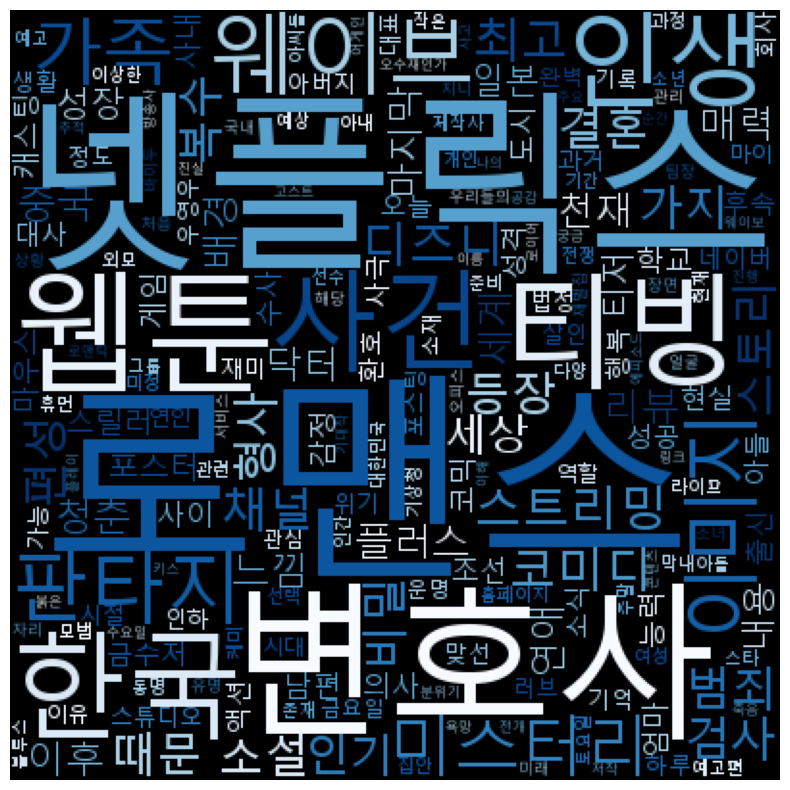

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

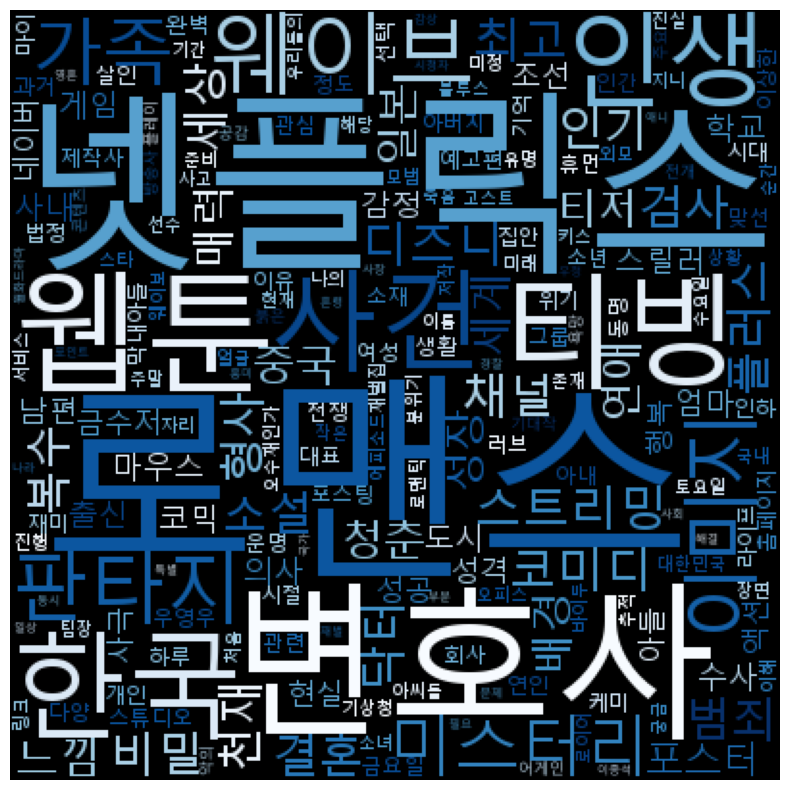

In [26]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'예고', '캐스팅', '대사', '편성', '가능', '이후', '때문', '역할', '등장', '환호',
             '마지막', '오늘', '예상', '과정', '관리', '기록', '가지', '후속', '스토리', '리뷰',
             '역할', '능력', '내용', '소식', '사이'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [31]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'로맨스': 140,
 '한국': 135,
 '넷플릭스': 114,
 '중국': 101,
 '웨이보': 87,
 '텐센트': 77,
 '티빙': 65,
 '도시': 64,
 '바이두': 54,
 '웨이브': 52,
 '판타지': 50,
 '변호사': 49,
 '아이치': 49,
 '웹툰': 48,
 '디즈니': 45,
 '스트리밍': 44,
 '백과': 44,
 '금요일': 42,
 '일본': 37,
 '코미디': 35,
 '플러스': 33,
 '닥터': 31,
 '토요일': 30,
 '채널': 30,
 '사극': 30,
 '소식': 29,
 '수요일': 28,
 '미스터리': 27,
 '망고': 27,
 '청춘': 27,
 '오늘': 26,
 '유쿠': 26,
 '링크': 25,
 '이미지': 25,
 '연애': 25,
 '캐스팅': 24,
 '작은': 24,
 '아씨들': 24,
 '오수재인가': 23,
 '법정': 22,
 '기대작': 22,
 '월요일': 22,
 '사내': 21,
 '고스트': 20,
 '월화': 20,
 '후속': 20,
 '마지막': 20,
 '클리닝': 19,
 '성장': 19,
 '인생': 19,
 '이후': 19,
 '기간': 19,
 '리뷰': 18,
 '슈룹': 18,
 '우영우': 18,
 '러브': 18,
 '인기': 18,
 '액션': 18,
 '소설': 17,
 '학교': 17,
 '맞선': 17,
 '네이버': 17,
 '이상한': 17,
 '조선': 17,
 '환호': 17,
 '붉은': 17,
 '형사': 17,
 '크레이지': 16,
 '최고': 16,
 '범죄': 16,
 '별똥별': 16,
 '현재': 16,
 '단심': 16,
 '마우스': 16,
 '편성': 16,
 '게임': 16,
 '휴먼': 16,
 '배경': 16,
 '스릴러': 16,
 '방송사': 15,
 '천재': 15,
 '포스터': 15,
 '회차': 15,
 '종료': 15,
 '주말': 15,
 '비밀': 15,
 '포스팅': 1

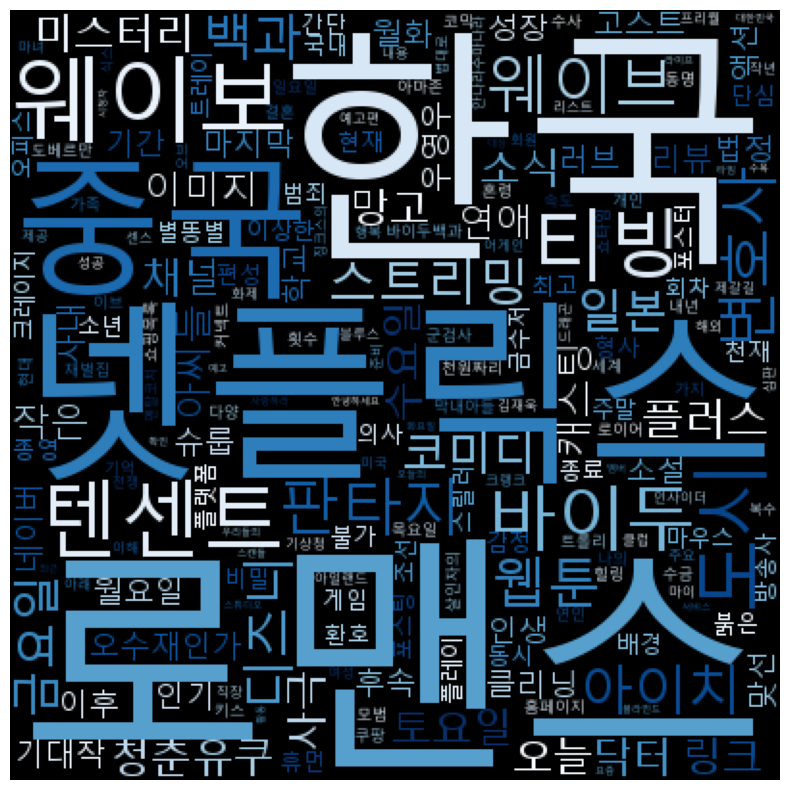

In [32]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

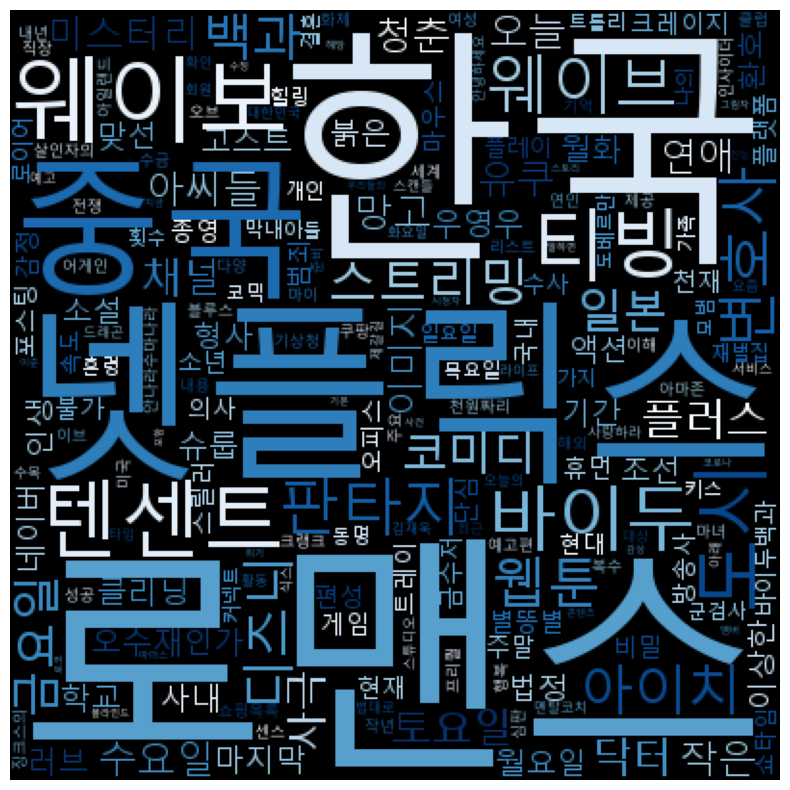

In [33]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'캐스팅', '성장', '간단', '이후', '인기', '기대작', '후속', '동시',
             '리뷰', '소식', '배경', '링크', '홈페이지', '종료', '회차', '포스터', '최고'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [34]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'중국': 181,
 '한국': 126,
 '넷플릭스': 63,
 '로맨스': 45,
 '티빙': 41,
 '웹툰': 39,
 '웨이브': 38,
 '디즈니': 25,
 '플러스': 22,
 '일본': 21,
 '판타지': 21,
 '기대작': 20,
 '종료': 19,
 '변호사': 18,
 '닥터': 17,
 '스릴러': 17,
 '사극': 17,
 '법정': 14,
 '마우스': 14,
 '범죄': 14,
 '러브': 13,
 '학교': 13,
 '월화드라마': 13,
 '코믹': 12,
 '재벌집': 12,
 '막내아들': 12,
 '연애': 12,
 '중드': 12,
 '액션': 11,
 '채널': 11,
 '오수재인가': 11,
 '사내': 11,
 '금요일': 11,
 '아씨들': 11,
 '작은': 11,
 '토요일': 11,
 '슈룹': 11,
 '맞선': 10,
 '환호': 10,
 '청춘': 10,
 '링크': 9,
 '나의': 9,
 '소식': 9,
 '등장': 9,
 '블루스': 9,
 '아이치': 9,
 '크레이지': 9,
 '최신': 9,
 '로이어': 9,
 '게임': 9,
 '예고편': 9,
 '미드': 9,
 '결산': 9,
 '왓챠': 8,
 '모범': 8,
 '인기': 8,
 '우영우': 8,
 '속도': 8,
 '수목드라마': 8,
 '금수저': 8,
 '클리닝': 8,
 '리스트': 8,
 '미국': 8,
 '연인': 8,
 '우리들의': 8,
 '김희선': 7,
 '사랑하라': 7,
 '쇼타임': 7,
 '고스트': 7,
 '일정': 7,
 '캐스팅': 7,
 '수요일': 7,
 '기상청': 7,
 '주말': 7,
 '비밀': 7,
 '최고': 7,
 '인생': 7,
 '로코': 7,
 '이상한': 7,
 '가족': 7,
 '법대로': 7,
 '오늘의': 6,
 '붉은': 6,
 '소방서': 6,
 '임수향': 6,
 '도베르만': 6,
 '리뷰': 6,
 '문가영': 6,
 '월요일': 6,
 '마이': 6,
 '징

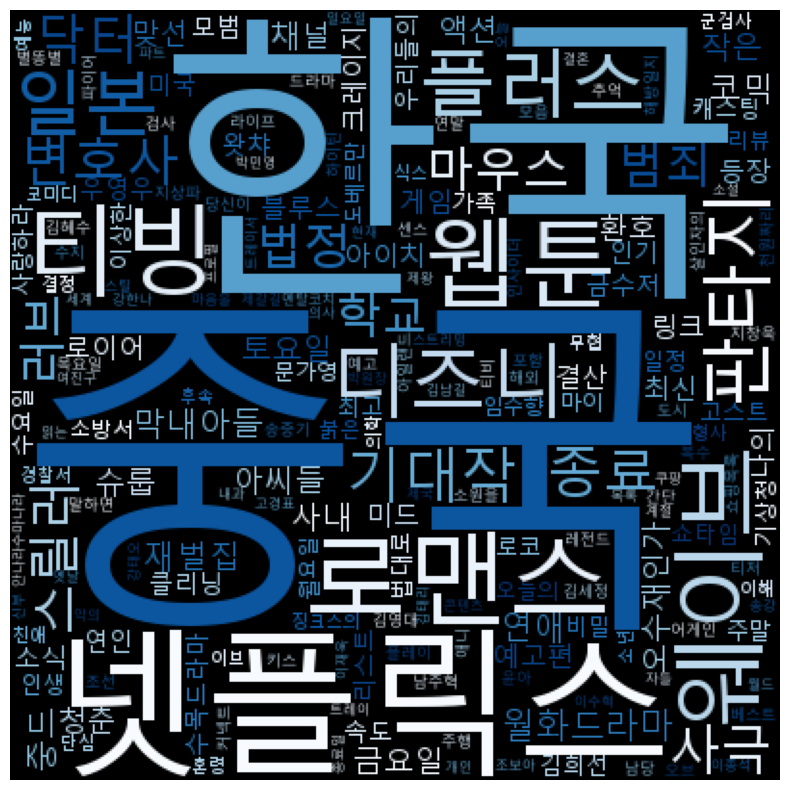

In [36]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

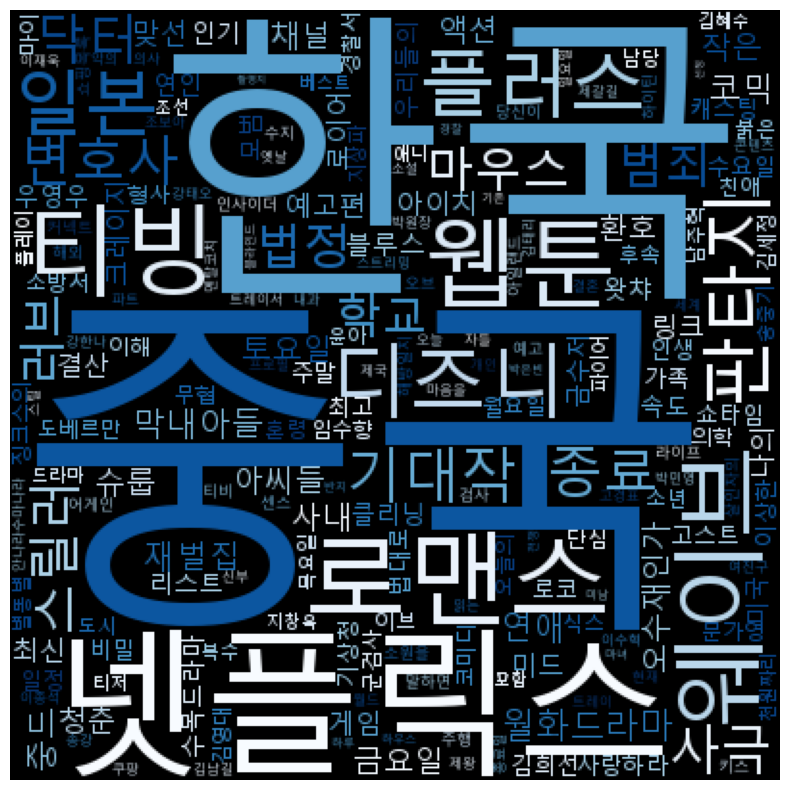

In [37]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'예능', '결정', '소식', '등장', '리뷰', '간단', '목록', '계절', '레전드', '연말',
             '모음', '추억'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기